<img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

<img width="800" style="float:center" 
     src="https://www.arvigbusiness.com/wp-content/uploads/Blog/For_Home/2019/January/Other/Phishing_Scam_Horizontal.png" />

### MEMBERS
-   Federico Cañadas
-   Lutho Dabula
-   Lia Dollison
-   Jesus Fuster
-   Paulino Herrera
-   Andrea Palomino
-   Jhonny Naime
-   Sergio Reyes

---

## 1. Setting Up

In [1]:
import findspark
findspark.init()

We create the SparkSession

In [51]:
import pyspark
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import when, col, explode, array, lit, desc
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
import pandas as pd
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.linalg import SparseVector
from pyspark.ml.feature import OneHotEncoder, StringIndexer

import matplotlib.pyplot as plt
from pyspark.sql.functions import col, desc, avg



import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "graphframes:graphframes:0.8.2-spark3.2-s_2.12" --jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'



In [44]:
from graphframes import *
import networkx as nx

In [3]:


spark = (SparkSession.builder
    .appName("Group2 - Analytics - FinalProject")
    .config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")
    .enableHiveSupport()
    .getOrCreate())

Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars


:: loading settings :: url = jar:file:/opt/spark3/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1e34b800-3b0c-45d2-904a-9ba7c68df890;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 136ms :: artifacts dl 3ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-1e34b800-3b0c-45d2-90

## 2. Importing the data 🛬

Crearting merchant table

In [4]:
Merchant = (spark.read.option("header","true")
                 .option("inferSchema","true")
                 .csv("hdfs://localhost:9000/GroupB/Datalake/Merchant/")
                 .cache())

print(f"There are {Merchant.count()} rows in the datasets")

There are 54213 rows in the datasets


Creating Label table

In [5]:
Label = (spark.read.option("header","true")
                 .option("inferSchema","true")
                 .csv("hdfs://localhost:9000/GroupB/Datalake/Label/")
                 .cache())

print(f"There are {Merchant.count()} rows in the datasets")

There are 54213 rows in the datasets


Creating Order Table

In [6]:
Orders = (spark.read.option("header","true")
                 .option("inferSchema","true")
                 .csv("hdfs://localhost:9000/GroupB/Datalake/Orders/")
                 .cache())

print(f"There are {Merchant.count()} rows in the datasets")

There are 54213 rows in the datasets


Filling null values for target with 0

In [7]:
label=Label.fillna({'Fraudster':0})

Merging tables

In [8]:


main_table = Orders.join(Merchant, Orders.Merchant_ID == Merchant.Merchant_ID, "left") \
                    .join(Label, Orders.Merchant_ID == Label.Merchant_ID, "left")

### Checking for null values

In [9]:
main_table.summary().toPandas()

,summary,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Merchant_ID,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Merchant_ID,Fraudster
0,count,54213,54213,54213,54213,54213,54213,54213,54213,54213,54213,54213,54213,54213,54213,54213,54213
1,mean,137966.28520834487,Infinity,None,92.23023997934075,None,None,200395.17621234758,1746213.0,200395.17621234758,None,None,None,33.12224005312379,None,200395.17621234758,0.09268994521609208
2,stddev,15563.51615619845,NaN,None,45.67326314638293,None,None,115398.4868945644,0.0,115398.4868945644,None,None,None,8.630091067648285,None,115398.4868945644,0.2900001216580233
3,min,111234,00004e323a70,2018-01-03 00:00:46,22,Ads,Cash On Delivery,2,1746213,2,2018-01-01 00:00:45,AAABPORUVEUVT,F,18,0.0.203.125,2,0
4,25%,124462,4.6476247348E11,None,55,None,None,100997,1746213,100997,None,None,None,27,None,100997,0
5,50%,137860,8.267479797E12,None,88,None,None,200548,1746213,200548,None,None,None,32,None,200548,0
6,75%,151403,Infinity,None,122,None,None,300382,1746213,300382,None,None,None,39,None,300382,0
7,max,165000,ffff961ce6cb,2018-12-16 23:08:09,385,SEO,Internet Banking,399993,1746213,399993,2018-08-18 04:40:29,ZZZXYHUYYPPLW,M,72,99.95.66.191,399993,1


# 3. EDA

In [10]:
#dropping columns irrelevant to target prediction such as unique identifiers
main_table = main_table.drop('Order_ID','Merchant_ID','Ecommerce_Provider_ID','IP_Address','Customer_ID')

In [11]:
#analyzing the impact of gender on being a "fraudster"
main_table.groupBy("Gender","Fraudster").count().toPandas()

,Gender,Fraudster,count
0,M,1,2990
1,F,0,20417
2,F,1,2035
3,M,0,28771


In [12]:
#people in their 30's commit more fraud
main_table.groupBy("Age").sum('Fraudster').toPandas()

,Age,sum(Fraudster)
0,31,229
1,65,0
2,53,25
3,34,203
4,28,218
5,26,158
6,27,179
7,44,79
8,22,115
9,47,61


In [13]:
#analyzing the impact of order source on being a "fraudster"
main_table.groupBy("Order_Source").sum('Fraudster').toPandas()

,Order_Source,sum(Fraudster)
0,SEO,1893
1,Direct,1171
2,Ads,1961


In [14]:
#analyzing the impact of payment method on being a "fraudster"
main_table.groupBy("Order_Payment_Method").sum('Fraudster').toPandas()

,Order_Payment_Method,sum(Fraudster)
0,Credit Card,2162
1,Internet Banking,1134
2,Cash On Delivery,112
3,E-wallet,801
4,Debit Card,816


# 4. Feature Engineering

#### Creating multiple merchants column

In [15]:
#creating column thats shows when a device has more than one merchant registered to it
#main_table = main_table.withColumn("MULTIPLE_MERCHANTS",
                                   #when(col("Registered_Device_ID") > 1, 1).otherwise(0)
                                 # )

#### Creating quartly column

In [16]:

#main_table = main_table.withColumn("hour",regexp_extract(col("Date_of_Order"),'.*\s(\d+):\d+:\d+', 1))
main_table = main_table.withColumn("Quarter",regexp_extract(col("Date_of_Order"),'.-(\d+)-.', 1))

#main_table=main_table.withColumn('trim',2023-col('year_company'))

main_table = main_table.replace(
               ['01','02', '03', '04','05','06','07','08','09','10','11','12'],
               ['Q1','Q1','Q1','Q2','Q2',  'Q2',  'Q3',  'Q3',  'Q3','Q4','Q4','Q4'])



In [17]:
main_table.groupBy("Quarter").sum('Fraudster').toPandas()

,Quarter,sum(Fraudster)
0,Q2,914
1,Q1,2973
2,Q3,864
3,Q4,274


In [18]:
main_table.limit(5).toPandas()

,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,Fraudster,Quarter
0,2018-04-29 16:39:26,148,Direct,Credit Card,2018-04-19 00:48:20,BEJVAJMFDUVOQ,M,30,0,Q2
1,2018-06-16 17:05:40,145,SEO,Credit Card,2018-05-15 23:30:37,GFHLOGZGFHNYH,F,20,0,Q2
2,2018-10-26 18:00:46,62,Ads,Internet Banking,2018-08-11 04:12:15,MTELXLHIBWHGI,F,46,1,Q4
3,2018-12-12 05:41:52,28,SEO,Debit Card,2018-08-17 01:52:14,ZPJCMOXVRXVJF,M,37,0,Q4
4,2018-09-20 11:06:10,70,Ads,Credit Card,2018-05-26 11:58:33,NVDDVXILKZTVO,F,26,0,Q3


#### Attempted to analyze how years within the company effected the target variable, but saw a decrease in score

In [20]:
#main_table = main_table.drop('year_company')
#main_table = main_table.withColumn("year_company",regexp_extract(col("Merchant_Registration_Date"),'(\d+)-.',1))
#main_table=main_table.withColumn('year_company',2023-col('year_company'))
#main_table.groupBy('year_company').count().toPandas()

## GRAPH

In [47]:
#filtering the fraudsters
main_fraudsters = main_table.filter(main_table.Fraudster == 1)


# Define the schema for the vertices
vertexSchema = (main_fraudsters.withColumnRenamed("Order_Payment_Method", "id").distinct())

# Define the schema for the edges
edgeSchema = (main_fraudsters.withColumnRenamed("Order_Source", "src")
              .withColumnRenamed("Order_Payment_Method", "dst")
              .withColumnRenamed("Gender", "gnd"))

# Create the GraphFrame
g = GraphFrame(vertexSchema, edgeSchema)

pr = g.pageRank(resetProbability=0.15, maxIter=10)
pr.vertices.orderBy("Order_Value_USD",ascending=False).toPandas().head(15)

,Order_Value_USD,Order_Source,id,Gender,Age,Fraudster,Quarter,pagerank
0,270,SEO,E-wallet,M,43,1,Q2,1.0
1,252,SEO,Internet Banking,M,24,1,Q4,1.0
2,250,Direct,Credit Card,F,46,1,Q1,1.0
3,250,Direct,Internet Banking,M,34,1,Q1,1.0
4,245,SEO,Credit Card,F,23,1,Q2,1.0
5,245,Ads,Debit Card,M,53,1,Q2,1.0
6,240,Ads,E-wallet,M,43,1,Q3,1.0
7,238,SEO,E-wallet,M,42,1,Q2,1.0
8,238,SEO,E-wallet,F,29,1,Q3,1.0
9,238,Ads,E-wallet,F,38,1,Q3,1.0


In [48]:
# Count number of edges per source and payment method
edge_counts = g.edges.groupBy("src", "dst").count().orderBy(desc("count"))


edge_counts.orderBy("count",ascending=False).toPandas().head(15)

,src,dst,count
0,Ads,Credit Card,7632
1,SEO,Credit Card,6732
2,Direct,Credit Card,4932
3,Ads,Internet Banking,3987
4,SEO,Internet Banking,3654
5,SEO,E-wallet,3051
6,SEO,Debit Card,3033
7,Ads,E-wallet,2925
8,Ads,Debit Card,2745
9,Direct,Internet Banking,2511


In [49]:
gender_fraudster = main_fraudsters.groupBy("Gender").count().orderBy("Gender")
gender_fraudster.toPandas()

,Gender,count
0,F,18243
1,M,26721


In [52]:
top_order_sources = g.vertices.groupBy("id").agg(avg("Order_Value_USD").alias("avg_order_value")).orderBy(desc("avg_order_value")).limit(5)
top_order_sources.toPandas()

,id,avg_order_value
0,Credit Card,93.082677
1,E-wallet,92.554865
2,Debit Card,92.382692
3,Internet Banking,91.467811
4,Cash On Delivery,88.179104


In [53]:
avg_ord_val = main_fraudsters.groupBy("Order_Source").agg(avg("Order_Value_USD").alias("avg_order_value")).orderBy("Order_Source")

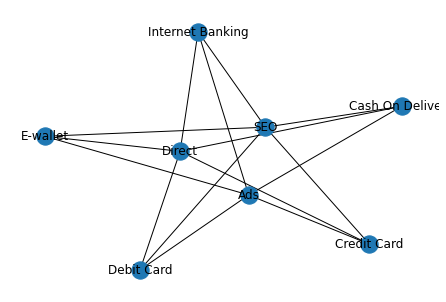

In [54]:
# Create an empty NetworkX graph
nx_g = nx.Graph()

# Add the vertices to the graph
for row in vertexSchema.collect():
    nx_g.add_node(row['id'])

# Add the edges to the graph
for row in edgeSchema.collect():
    nx_g.add_edge(row['src'], row['dst'])

# Draw the graph using NetworkX
pos = nx.spring_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True)

# Show the graph using Matplotlib
plt.show()

In [55]:
# Define the schema for the vertices
vertexSchema = (main_fraudsters.withColumnRenamed("Order_Payment_Method", "id").distinct())

# Define the schema for the edges
edgeSchema = (main_fraudsters.withColumnRenamed("Order_Source", "src")
              .withColumnRenamed("Order_Payment_Method", "dst")
              .withColumnRenamed("Gender", "gnd"))
# Create the GraphFrame
g = GraphFrame(vertexSchema, edgeSchema)

#We tried to do a graph with device and merchant id
#### Define the schema for the vertices
vertexSchema = (main_fraudsters.withColumnRenamed("Registered_Device_ID", "id").distinct())

### Define the schema for the edges
edgeSchema = (main_fraudsters.withColumnRenamed("MULTIPLE_MERCHANTS", "src")
              .withColumnRenamed("Registered_Device_ID", "dst")
)
#### Create the GraphFrame
g = GraphFrame(vertexSchema, edgeSchema)

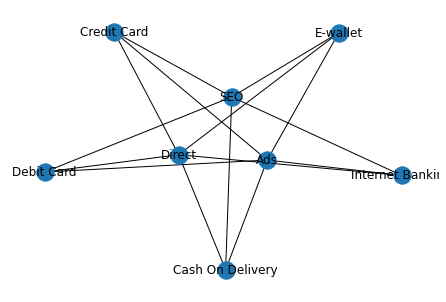

In [59]:
# Create an empty NetworkX graph
nx_g = nx.Graph()

# Add the vertices to the graph
for row in vertexSchema.collect():
    nx_g.add_node(row['id'])

# Add the edges to the graph
for row in edgeSchema.collect():
    nx_g.add_edge(row['src'], row['dst'])

# Draw the graph using NetworkX
pos = nx.spring_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True)

# Show the graph using Matplotlib
plt.show()

#### After creating new features and having the graph we drop columns used to create new features

In [20]:
main_table = main_table.drop('Date_of_Order', 'Merchant_Registration_Date','Registered_Device_ID')


In [21]:
main_table.printSchema()

root
 |-- Order_Value_USD: integer (nullable = true)
 |-- Order_Source: string (nullable = true)
 |-- Order_Payment_Method: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Fraudster: integer (nullable = true)
 |-- Quarter: string (nullable = true)



## 5. OVERSAMPLING

In [22]:
# analyzing current proportion of 0 and 1 in the dataset
main_table.groupBy("Fraudster").count().toPandas()

,Fraudster,count
0,1,5025
1,0,49188


In [23]:
#calculating current ration of smaller portion to larger proportion. We will use this value to perform oversampling

major_df = main_table.filter(col("Fraudster") == 0)
minor_df = main_table.filter(col("Fraudster") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 9


In [24]:
#performing oversampling to balance classes
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
main_table = major_df.unionAll(oversampled_df)


## 6. OHE

In [25]:



label_column = "Fraudster"
#defining which columns are categorical and which are numerical. these variables will be used to perform the OHE
categoricalCols = [field for (field, dataType) in main_table.dtypes if ((dataType == "string") & (field != label_column))]
numericCols = [field for (field, dataType) in main_table.dtypes if ((dataType == "int") & (field != label_column))]

print (f"categorical columns: {categoricalCols}")
print (f"numerical columns: {numericCols}")


#setting up names for variables on which we perform OHE
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

#applying the OHE
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols, handleInvalid="skip")

oheEncoder = OneHotEncoder(inputCols=indexOutputCols,outputCols=oheOutputCols)

temp_df = stringIndexer.fit(main_table).transform(main_table)

oheEncoder.fit(temp_df).transform(temp_df).toPandas()

#merging the OHE columns with the numerical columns
assemblerInputs = oheOutputCols + numericCols
print("Feature columns: ",assemblerInputs)

vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")


categorical columns: ['Order_Source', 'Order_Payment_Method', 'Gender', 'Quarter']
numerical columns: ['Order_Value_USD', 'Age']


Feature columns:  ['Order_SourceOHE', 'Order_Payment_MethodOHE', 'GenderOHE', 'QuarterOHE', 'Order_Value_USD', 'Age']


## 7. Checking for and handling outliers

#### Age

In [26]:
#calculating the quartiles
quartiles = main_table.approxQuantile("Age", [0.25, 0.75], 0.01)

#calculating the interquartile range
iqr = quartiles[1] - quartiles[0]

#calculating the lower and upper bounds for outliers
lower_bound = quartiles[0] - 1.5 * iqr
upper_bound = quartiles[1] + 1.5 * iqr

#filtering out the outliers
main_table = main_table.filter((main_table.Age >= lower_bound) & (main_table.Age <= upper_bound))

#### Order Value

In [27]:
#calculating the quartiles
quartiles = main_table.approxQuantile("Order_Value_USD", [0.25, 0.75], 0.01)

#calculating the interquartile range
iqr = quartiles[1] - quartiles[0]

#calculating the lower and upper bounds for outliers
lower_bound = quartiles[0] - 1.5 * iqr
upper_bound = quartiles[1] + 1.5 * iqr

#filtering out the outliers
main_table = main_table.filter((main_table.Age >= lower_bound) & (main_table.Age <= upper_bound))

## 8. MODELING

In [28]:
#setting up the models we would like to use
#given that it is a binary classication problem and we want to know which characteristics determine a "fraudster",
#we are only observing tree based models 
seed=123





dt = DecisionTreeClassifier(labelCol="Fraudster", featuresCol="features",seed=seed)
rf = RandomForestClassifier(labelCol="Fraudster", featuresCol="features",maxDepth=10,seed=seed)
gbt = GBTClassifier(labelCol="Fraudster", featuresCol="features",maxIter=10,seed=seed)

classifiers = [dt,rf,gbt]
classifiers

[DecisionTreeClassifier_b238132a99c2,
 RandomForestClassifier_807e1363bde3,
 GBTClassifier_36c72fe092a0]

In [29]:
#creating the pipeline and setting up the steps that we want in our pipeline
def create_pipeline(classifier):
    return Pipeline(stages = [ stringIndexer,oheEncoder,vecAssembler,classifier])

pipelines = [create_pipeline(classifier) for classifier in classifiers]
pipelines

[Pipeline_d47cee7d54d6, Pipeline_cb4d3ac2a4c1, Pipeline_b34acce25b32]

In [30]:
#determining the metric we want to use to evaluate the tree models that we define in the previous step

evaluator = BinaryClassificationEvaluator(labelCol='Fraudster', metricName='areaUnderROC')


In [31]:
#splitting the dataset in order to get train and test dataset 
(trainingData, testData) = main_table.randomSplit([0.7,0.3],seed=seed)

In [32]:
#ensuring that we have the same number of 0 and 1 values in the train and test datasets
(trainingData1, testData1) = main_table.where("Fraudster=0").randomSplit([0.7,0.3],seed=seed)
(trainingData2, testData2) = main_table.where("Fraudster=1").randomSplit([0.7,0.3],seed=seed)

trainingData = trainingData1.unionByName(trainingData2)
testData = testData1.unionByName(testData2)

In [33]:
testData.limit(4).toPandas()

,Order_Value_USD,Order_Source,Order_Payment_Method,Gender,Age,Fraudster,Quarter
0,22,Ads,Cash On Delivery,M,35,0,Q1
1,22,Ads,Credit Card,F,20,0,Q2
2,22,Ads,Credit Card,F,24,0,Q2
3,22,Ads,Credit Card,F,28,0,Q3


In [34]:
#fitting the models
models = [pipeline.fit(trainingData) for pipeline in pipelines]
models

[PipelineModel_38d627f96974,
 PipelineModel_97c18ba3cac7,
 PipelineModel_c79c320a4a9d]

In [35]:
#creating a function that evaluates each model with the metric specified previously 


names = []
values = [] 
for model in models:
    prediction_df = model.transform(testData)
    accuracy = evaluator.evaluate(prediction_df)
    names.append(type(model.stages[-1]).__name__) # the algorithm is the last stage in the pipeline
    values.append(accuracy)

data = {'name':names,'AUC Score':values,'model':models}
df = pd.DataFrame(data)
df.sort_values(by=['AUC Score'], inplace=True, ascending=False)  
df

,name,AUC Score,model
1,RandomForestClassificationModel,0.829805,PipelineModel_97c18ba3cac7
2,GBTClassificationModel,0.758805,PipelineModel_c79c320a4a9d
0,DecisionTreeClassificationModel,0.280750,PipelineModel_38d627f96974


In [36]:
#determining the best model
best_model=df.iloc[0]['model']

In [37]:
#checking the way in which the 0 and 1 are being classified by the model
best_model.transform(testData).groupby("Fraudster").pivot("prediction").count().toPandas()

,Fraudster,0.0,1.0
0,1,5596,8005
1,0,12742,2058


In [38]:
rfModel=best_model.stages[-1]
rfModel

RandomForestClassificationModel: uid=RandomForestClassifier_807e1363bde3, numTrees=20, numClasses=2, numFeatures=12

In [39]:
# FEATURE IMPORTANCES
rfModel.featureImportances


SparseVector(12, {0: 0.008, 1: 0.0086, 2: 0.0066, 3: 0.0064, 4: 0.0064, 5: 0.0057, 6: 0.0097, 7: 0.6692, 8: 0.0815, 9: 0.0663, 10: 0.0685, 11: 0.063})

In [41]:

va = best_model.stages[-2]
tree = best_model.stages[-1]

#visualize the decision tree model
#display(tree) 
##print the nodes of the decision tree model
#print(tree.toDebugString) 

list(zip(va.getInputCols(), tree.featureImportances))

[('Order_SourceOHE', 0.007968499857571828),
 ('Order_Payment_MethodOHE', 0.008597685994469684),
 ('GenderOHE', 0.006642721210111967),
 ('QuarterOHE', 0.0063569017734571845),
 ('Order_Value_USD', 0.00643997792045671),
 ('Age', 0.005702050198033055)]